Install dependencies

In [5]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Server Code (TCP) - Too slow

In [ ]:
import socket

HOST, PORT = "localhost", 4000

s_srvr = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s_srvr.bind((HOST, PORT))
print (HOST , PORT)

import json

def srvr_read():
    try:
        data = conn.recv(64)
    except socket.error:
        print ("Error Occured.")
        
    return data

def srvr_write(data):
    try:
        conn.send(str(data).encode("utf-8"))
    except socket.error:
        print ("Error Occured.")

def shutdown_conns():
    conn.close()
    s_srvr.close()

In [ ]:
import time

# Listen for connection and connect
s_srvr.listen(1)
conn, addr = s_srvr.accept()
print('Connected by', addr)

voltage = []

cmd = json.dumps({"cmd":1}) # 1 = continue, 0 = stop

while True:

    srvr_write(cmd)

    start = time.time()
    data = srvr_read()
    end = time.time()

    print("time for client to process and send:", end-start)

    data_s = json.loads(data)

    if data_s["end"] == True:
        break
    voltage.append(data_s["vk"])

    #print(voltage[-1])


Server Code - UDP (Twice as fast but still slow)

In [ ]:
import socket

upd_ip_addr = "127.0.0.1"

udp_port_in = 40408
upd_port_out = 40404

udp_conn = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
udp_conn.bind((upd_ip_addr, udp_port_in))

import json

def udp_read():
    try:
        data, addr = udp_conn.recvfrom(128)
        return data
    except socket.error:
        print ("Error Occured.")

def udp_write(data):
    try:
        udp_conn.sendto(str(data).encode("utf-8"), (upd_ip_addr, upd_port_out))
    except socket.error:
        print ("Error Occured.")

In [ ]:
import time

voltage = []

cmd = json.dumps({"cmd":1}) # 1 = continue, 0 = stop

while True:

    udp_write(cmd)

    start = time.time()
    data_in = udp_read()
    end = time.time()

    print("time for client to process and send:", end-start)

    data_s = json.loads(data_in)

    if data_s["end"] == True:
        break
    voltage.append(data_s["vk"])

    #print(voltage[-1])

MemMap

In [ ]:
import mmap
import struct

f_in = open("simCell_out.dat", "r+b")
# memory-map the file, size 0 means whole file
mm_in = mmap.mmap(f_in.fileno(), 0)

# read content via standard file methods
mm_in.seek(0)
bytes = mm_in.read(24)
print(struct.unpack("ddd", bytes))

# close the map
mm_in.close()
f_in.close()

In [ ]:
import mmap
import struct

sync = 0
cmd = 0
feedback = 0

f_out = open("simCell_in.dat", "w+b")
f_out.write(struct.pack("ddd", sync, cmd, feedback))
f_out.flush()
# memory-map the file, size 0 means whole file
mm_out = mmap.mmap(f_out.fileno(), 0)
# read content via standard file methods
mm_out.seek(0)
mm_out.write(struct.pack("ddd", *([1]*3)))
print(struct.unpack("ddd", mm_out))

# close the map
mm_out.close()
f_out.close()

In [2]:
import mmap
import struct

def file_clear():

    f = open("simCell_in.dat", "w+b")
    f.write(struct.pack("ddd", 0, 0, 0))
    f.flush()
    f.close()

    f = open("simCell_out.dat", "w+b")
    f.write(struct.pack("ddd", 0, 0, 0))
    f.flush()
    f.close()

    del f


def mmap_init():
    f_in = open("simCell_out.dat", "r+b")
    mm_in = mmap.mmap(f_in.fileno(), 0)

    f_out = open("simCell_in.dat", "a+b")
    mm_out = mmap.mmap(f_out.fileno(), 0)

    return mm_in, f_in, mm_out, f_out
    
def read_mmap():

    mm_in.seek(0)
    bytes = struct.unpack("ddd", mm_in.read(8*3))
    return bytes

def write_mmap(sync, cmd, feedback):
    
    mm_out.seek(0)
    mm_out.write(struct.pack("ddd", sync, cmd, feedback))
    #mm_out.flush()

def mmap_close():
    try:
        mm_out.close()
    except:
        print("mm_out already closed")
    try:
        f_out.close()
    except:
        print("f_out already closed")
    try:
        mm_in.close()
    except:
        print("mm_in already closed")
    try:
        f_in.close()
    except:
        print("f_in already closed")

In [ ]:
import time

file_clear()

mm_in, f_in, mm_out, f_out = mmap_init()

voltage = []

cmd = 1
feedback = 0
sync = 0


while True:

    sync = sync + 1
    write_mmap(sync, cmd, feedback)

    #start = time.time()
    
    data_in = read_mmap()
    while sync != data_in[0]:
        data_in = read_mmap()

    #end = time.time()
    #print("time for client to process and send:", end-start)

    voltage.append(data_in[2])

    if data_in[1] == False:
        break

    #print(voltage[-1])

cmd = 0
write_mmap(sync+1, cmd, feedback)

mmap_close()

Memory Map with Library

In [3]:
import subprocess
import time
import mmapTx

def getSimData():

    mmaptx = mmapTx.Mmaptx(name="simCell", format_type="d", in_size=2, out_size=2, blocking=True)

    data_list = []
    cmd = 1
    feedback = 0
    start = time.time()

    # Start recieving data
    while True:

        mmaptx.write(cmd, feedback)
        data_in = mmaptx.read()
        data_list.append(data_in[1])

        if data_in[0] == False:
            break

        #print(voltage[-1])

    # Send 
    cmd = 0 # Send stop command
    mmaptx.write(cmd, feedback)

    # Print out time
    end = time.time()
    print("Execution time:", end-start)

    # Clean and close mmap
    mmaptx.cleanup()
    del mmaptx

    return data_list

def runSim():

    bin2str = lambda a: ["false","true"][a]

    # runSimulation input args:
    #   send2py - flag to allow data to be transferred to python
    #   plotSim - flag to allow the exe to plot graphs
    return subprocess.Popen(["runSimulation.exe"])

def startSim():
    process = runSim()
    data = getSimData()
    process.wait()
    return data

Plotting

Execution time: 14.880312204360962


<Axes: >

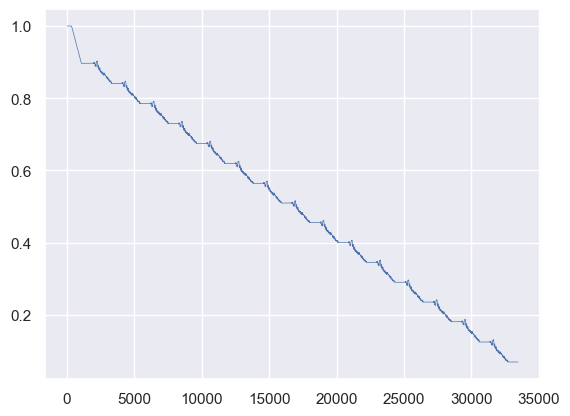

In [4]:
import seaborn as sns

data=startSim()

sns.set_theme()
sns.lineplot(data=data, linewidth = 0.5)
